## Predict Movie Revenue Using Linear Regression

### Can we predict a movie's box office revenue based on its production budget?

In [242]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.autograd import Variable

### Data Prep -- Create Clean CSV

In [243]:
data_path = "dirty_data.csv"
df = pd.read_csv(data_path)
df.drop(columns=['Rank', 'Release Date', 'Movie Title', 'Domestic Gross ($)'], inplace=True)
df.columns.values[0] = 'production_budget'
df.columns.values[1] = 'worldwide_gross'


def df_cleanup(df):
    for column in df.columns:
        for i in range(0, df.index.stop):
            temp_array = []
            for j in df.at[i,column]:
                if j == '$' or j == ',':
                    continue
                temp_array.append(j)
            df.at[i, column] = int("".join(temp_array))
            
    zeros = []
    for i in range(0, df.index.stop):
        if df.at[i, 'worldwide_gross'] == 0:
            zeros.append(df.index[i])
    
    df.drop(index=zeros, inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns="index", inplace=True)
    df.to_csv("clean_data.csv")
    return df

df_cleanup(df)

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


### Import Clean CSV

In [244]:
clean_csv_path = "clean_data.csv"
df2 = pd.read_csv(clean_csv_path)
df2.drop(columns='Unnamed: 0', inplace=True)
df2
# df2.describe()

,production_budget,worldwide_gross
0,110000,11000000
1,200000,8000000
2,100000,3000000
3,245000,22000000
4,3900000,9000000
...,...,...
5029,55000000,376856949
5030,40000000,166893990
5031,185000000,561137727
5032,175000000,140012608


In [245]:
# Normalization or Standardization. Choose. 

# Normalization (Min-Max)
from sklearn.preprocessing import MinMaxScaler
mmscale=MinMaxScaler()
#normalized_vals = mmscale.fit_transform(df2[['production_budget', 'worldwide_gross']])
#norm_df = pd.DataFrame(data=normalized_vals, columns = ['production_budget', 'worldwide_gross'])

# Standardization 
from sklearn.preprocessing import StandardScaler
standarizer = StandardScaler()
standarized_vals = standarizer.fit_transform(df2[['production_budget', 'worldwide_gross']])
datanew = pd.DataFrame(data=standarized_vals, columns = ['production_budget', 'worldwide_gross'])

In [246]:
# Normalization / Standardization 
x = norm_df['production_budget']
y = norm_df['worldwide_gross']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)                            
                            
x_train = np.array(x_train.values, dtype=np.float32).reshape(-1, 1)
x_test = np.array(x_test.values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_train.values, dtype=np.float32).reshape(-1, 1)
y_test = np.array(y_test.values, dtype=np.float32).reshape(-1, 1)


# Pytorch Neural Network Version

In [247]:
# Model Architecture -- Ax+b ([weight*input] + bias) 
# Entirely Linear so no activation function
# Only need to define how the input signal is processed
# Just specify how the neuron layer modifies its input signal
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

In [248]:
# 1 Input -- 1 Output
input_dim = 1
output_dim = 1
learning_rate = 0.1
epochs = 500

model = Model(input_dim, output_dim)
##### FOR GPU ######
if torch.cuda.is_available():
    model.cuda()
    
# Loss Function: Mean Squared Error
criterion = nn.MSELoss()

# Optimization: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epoch 0, loss 1.005812644958496
epoch 1, loss 0.6427268981933594
epoch 2, loss 0.4110510051250458
epoch 3, loss 0.2632239758968353
epoch 4, loss 0.16889850795269012
epoch 5, loss 0.10871089994907379
epoch 6, loss 0.07030569016933441
epoch 7, loss 0.04579920694231987
epoch 8, loss 0.030161114409565926
epoch 9, loss 0.020181696861982346
epoch 10, loss 0.01381292100995779
epoch 11, loss 0.009747995994985104
epoch 12, loss 0.007153097074478865
epoch 13, loss 0.00549618573859334
epoch 14, loss 0.004437781870365143
epoch 15, loss 0.003761273343116045
epoch 16, loss 0.003328444669023156
epoch 17, loss 0.003051105886697769
epoch 18, loss 0.002872985089197755
epoch 19, loss 0.0027581772301346064
epoch 20, loss 0.0026837706100195646
epoch 21, loss 0.002635148586705327
epoch 22, loss 0.002602982334792614
epoch 23, loss 0.002581320470198989
epoch 24, loss 0.002566365525126457
epoch 25, loss 0.0025556941982358694
epoch 26, loss 0.00254776026122272
epoch 27, loss 0.0025415769778192043
epoch 28, loss

epoch 248, loss 0.002067453460767865
epoch 249, loss 0.002066088607534766
epoch 250, loss 0.0020647291094064713
epoch 251, loss 0.002063374500721693
epoch 252, loss 0.002062025247141719
epoch 253, loss 0.0020606806501746178
epoch 254, loss 0.0020593416411429644
epoch 255, loss 0.0020580068230628967
epoch 256, loss 0.002056677360087633
epoch 257, loss 0.0020553527865558863
epoch 258, loss 0.0020540333352983
epoch 259, loss 0.0020527183078229427
epoch 260, loss 0.0020514086354523897
epoch 261, loss 0.0020501036196947098
epoch 262, loss 0.0020488034933805466
epoch 263, loss 0.0020475080236792564
epoch 264, loss 0.002046217443421483
epoch 265, loss 0.00204493198543787
epoch 266, loss 0.0020436509512364864
epoch 267, loss 0.0020423748064786196
epoch 268, loss 0.002041103085502982
epoch 269, loss 0.002039836486801505
epoch 270, loss 0.002038574544712901
epoch 271, loss 0.0020373170264065266
epoch 272, loss 0.0020360643975436687
epoch 273, loss 0.0020348161924630404
epoch 274, loss 0.00203357

epoch 484, loss 0.0018527079373598099
epoch 485, loss 0.0018521408783271909
epoch 486, loss 0.001851575798355043
epoch 487, loss 0.0018510128138586879
epoch 488, loss 0.0018504520412534475
epoch 489, loss 0.0018498931312933564
epoch 490, loss 0.0018493366660550237
epoch 491, loss 0.0018487820634618402
epoch 492, loss 0.0018482293235138059
epoch 493, loss 0.0018476789118722081
epoch 494, loss 0.0018471304792910814
epoch 495, loss 0.0018465841421857476
epoch 496, loss 0.001846039667725563
epoch 497, loss 0.0018454972887411714
epoch 498, loss 0.0018449570052325726
epoch 499, loss 0.001844418584369123


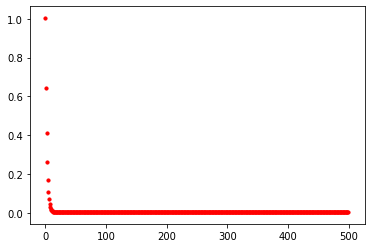

In [249]:
# Training 
params = []
for epoch in range(epochs):
    # Converting inputs and labels to variable 
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else: 
        print('GPU Not Available!')

    # Clear gradient buffers. 
    # Gradients from previous epoch not needed.
    # Don't want to cummulate gradients.
    optimizer.zero_grad()

    # Get output from model, given the inputs 
    y_hat = model(inputs)    
    
    # Get loss for the predicted output 
    loss = criterion(y_hat, labels)

    # Get gradients w.r.t the parameters 
    loss.backward()
    params.append(torch.nn.utils.parameters_to_vector(model.parameters()).data)
    # update parameters 
    optimizer.step()
    plt.scatter(epoch, loss.data.cpu(), color='r', s=10, marker='o')
    
    print(f'epoch {epoch}, loss {loss.item()}')

In [250]:
torch.nn.utils.parameters_to_vector(model.parameters()).data

tensor([ 0.5971, -0.0122], device='cuda:0')

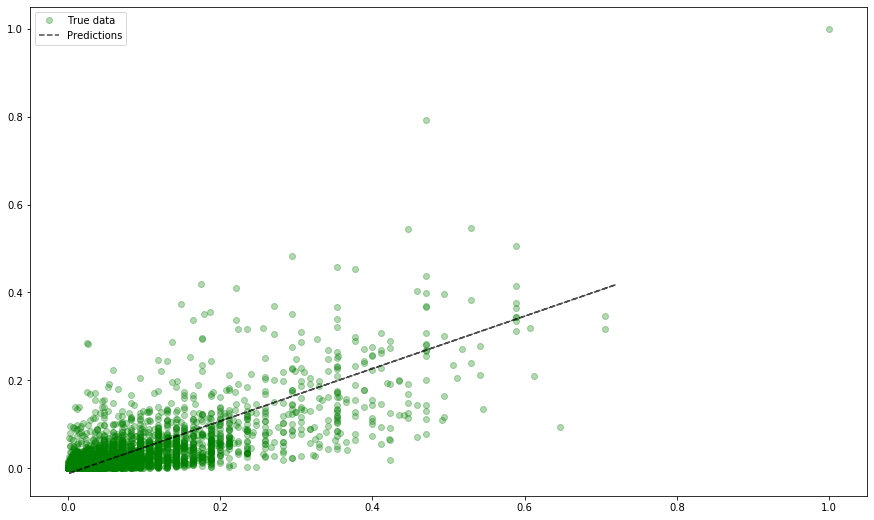

In [251]:
# Testing 
with torch.no_grad(): # Gradients not needed in testing phase.
    test_input = Variable(torch.from_numpy(x_test))
    if torch.cuda.is_available():
        predicted = model(test_input.cuda()).cpu().data.numpy()
        
    else:
        predicted = model(test_input).data.numpy()

plt.figure(figsize=[15,9])
plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.3)
plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.7, color='black')
plt.legend(loc='best')
plt.show()